# Recurrent Neural Networks

We'll introduce the concept of recurrent neural networks, which explicitly model the time-dependency of their inputs to facilitate the analysis of sequential data. We'll demonstrate this functionality using a weather forecasting dataset in a classic time-series analysis approach.


# Implement a Simple Recurrent Neural Network

We start with an example implementing the feed-forward pass of a recurrent neural network in NumPy. To keep things simple, we assume that the signal is a scalar value containing a single feature, corresponding to a binary signal. 


We can use a recurrent relation to implement a feedback "comb" filter.

In [ ]:
input_series = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
output_series = []

state = 0
U = 1 / 2
V = 1 - U
for input_data in input_series:
    hidden = U * input_data + V * state
    output_data = hidden
    state = output_data
    output_series.append(output_data)

print(f"Input Series: {[f'{x:.2f}' for x in input_series]}")
print(f"Output Series: {[f'{x:.2f}' for x in output_series]}")

In [ ]:
from matplotlib import pyplot as plt

plt.plot(input_series, label="input signal")
plt.plot(output_series, label="output signal")
plt.legend()
plt.show()

We modify the previous code to implement a more general recurrent neuron.

In [ ]:
import numpy as np


def sigmoid(x):
    """Simple implementation of sigmoid function."""
    return 1 / (1 + np.exp(-x))


input_series = [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
output_series = []

state = 0
U, V, W, b = np.random.normal(size=4)
for input_data in input_series:
    hidden = sigmoid(U * input_data + V * state + b)
    output_data = sigmoid(hidden * W)
    state = output_data
    output_series.append(output_data)

print(f"Input Series: {[f'{x:.2f}' for x in input_series]}")
print(f"Output Series: {[f'{x:.2f}' for x in output_series]}")

## Load Weather Dataset

We download the uncompressed dataset of the Jena Climate Dataset from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip.

More information on this dataset can be found at https://www.bgc-jena.mpg.de/wetter/.

In [2]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "weather_dataset")
if not os.path.exists(dataset_path):
    url = "https://s3.amazonaws.com/keras-datasets/" "jena_climate_2009_2016.csv.zip"
    download_url(url, ".")
    _extract_zip("jena_climate_2009_2016.csv.zip", dataset_path, None)
    os.remove("jena_climate_2009_2016.csv.zip")

This dataset contains 14 weather measurements in a `.csv` file. Their meaning is shown in the header.

In [3]:
import pandas as pd

filename = os.path.join(dataset_path, "jena_climate_2009_2016.csv")
dataframe = pd.read_csv(filename, index_col=0)
data = dataframe.values
header = dataframe.columns.tolist()
dataframe.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Visualize Data

We now visualize the 14 measured features of the dataset. For this, we use the `plot_data()` function.

```python
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data, header, start=0, samples_per_cycle=144, cycles=14):
    """Plot data highlighting periodic cycles."""

    fig, axes = plt.subplots(7, 2, figsize=(16, 12), sharex=True)

    for i, ax in enumerate(axes.flatten()):
        ax.plot(np.arange(start, start + samples_per_cycle * cycles),
                data[start:start + samples_per_cycle * cycles, i], 
                label=header[i])
        ax.legend()
        ax.set_xlim(start, start + samples_per_cycle * cycles)
        
        for cycle in range(1, cycles):
            ax.axvline(x=start + cycle * samples_per_cycle, 
                    color="gray", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()
```

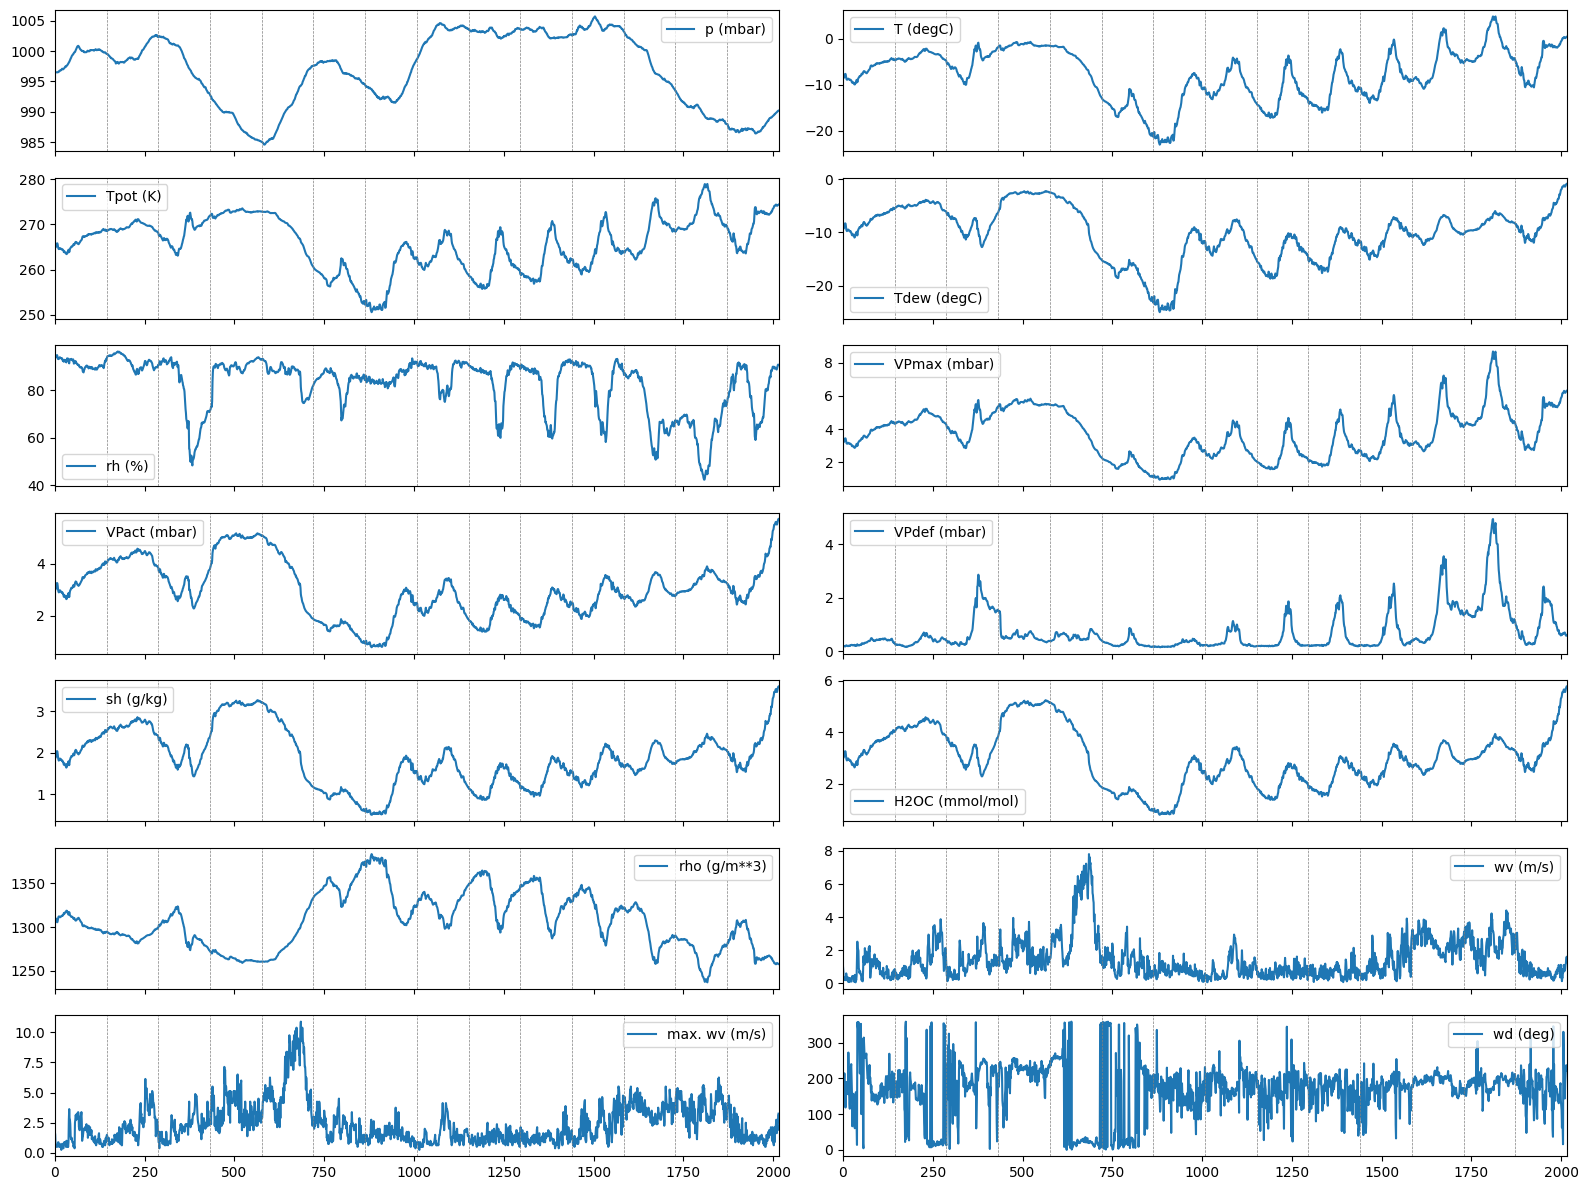

In [4]:
from for_rnn import plot_data

daily_samples = 144
n_days = 14

plot_data(data, header, samples_per_cycle=daily_samples, cycles=n_days)

## Preprocess Data

We start by removing the mean from the data and normalizing them by their standard deviation.

In [ ]:
# data -= data.mean(axis=0)
# data /= data.std(axis=0)

# plot_data(data, header, samples_per_cycle=daily_samples, cycles=n_days)

We now preprocess the data into time series to input into the neural network model, that is, they need to be of shape (batch size, number of samples, number of feature).

In [20]:
n_samples = data.shape[0]
n_features = data.shape[1]
past_seq = 2 * daily_samples  # Length of the sequences to be fed to the RNN.
lag = 71  # How many time_steps ahead in time the RNN should predict temperature.
temp_idx = 1  # Temperature (Celsius) index.

inputs, targets = [], []
for i in np.random.permutation(range(0, n_samples - past_seq - lag, daily_samples)):
    inputs.append(data[i : i + past_seq, :])
    targets.append(data[i + past_seq + lag : i + past_seq + lag + 1, temp_idx])
inputs = np.asarray(inputs)
targets = np.asarray(targets)

print(inputs.shape)
print(targets.shape)

(2918, 288, 14)
(2918, 1)


we use deeptrack to handle the data

In [23]:
import deeptrack as dt

sources = dt.sources.Source(inputs=inputs, targets=targets)
train_sources, val_sources = dt.sources.random_split(sources, [0.8, 0.2])

print(f"Number of training inputs = {len(train_sources)} / {len(sources)}")

Number of training inputs = 2043 / 2918


We start by creating a dataset and the respective data loaders.

In [25]:
import torch

train_mean = np.mean([source["inputs"] for source in train_sources], axis=(0, 1))
train_std = np.std([source["inputs"] for source in train_sources], axis=(0, 1))

inputs_pl = dt.Value(sources.inputs - train_mean) / (train_std) >> dt.pytorch.ToTensor(
    dtype=torch.float
)

targets_pl = dt.Value(sources.targets - train_mean[temp_idx]) / (train_std[temp_idx])

In [35]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(inputs_pl & targets_pl, inputs=train_sources)
val_dataset = dt.pytorch.Dataset(inputs_pl & targets_pl, inputs=val_sources)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Creating a Common-Sense Benchmark

We then create a baseline common-sense benchmark, generate benchmark for comparison, i.e., predict $T_t = T_{t-1}$.

In [36]:
temperature = data[:, temp_idx]
benchmark = np.mean(
    np.abs(
        temperature[lag + daily_samples :: daily_samples]
        - temperature[lag : -(daily_samples - lag) : daily_samples]
    )
)
print(benchmark)
std_bm = benchmark / (train_std[temp_idx])
print(std_bm)

2.6711750599520383
0.31635755144499883


In [ ]:
# import torch
# from torch.utils.data import random_split, TensorDataset, DataLoader

# # Convert to PyTorch tensors.
# inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
# targets_tensor = torch.tensor(targets, dtype=torch.float32)

# # Splitting the dataset into training, validation, and test
# dataset = TensorDataset(inputs_tensor, targets_tensor)
# train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.2, 0.1])

# # Creating data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Implement PyTorch RNN Model

This example introduces the `RNN` module in PyTorch.

In [37]:
import torch.nn as nn

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  ### device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)


# Define the RNN and Linear layers separately.
rnn = nn.RNN(input_size=inputs.shape[2], hidden_size=2, batch_first=True)
fc = nn.Linear(in_features=2, out_features=1)
rnn.to(device)
fc.to(device)

Linear(in_features=2, out_features=1, bias=True)

We now train the model.

In [38]:
criterion = nn.L1Loss()  # MAE loss.
optimizer = torch.optim.Adam(
    list(rnn.parameters()) + list(fc.parameters()), lr=0.001
)  # Optimizer.
epochs = 100

train_losses, val_losses = [], []
for epoch in range(epochs):

    # Training.
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(device)
        rnn_out, _ = rnn(inputs)  # RNN layer.
        rnn_out = rnn_out[:, -1, :]  # Select the last output for each sequence.
        outputs = fc(rnn_out)  # Linear layer.

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch} Training Loss: {train_losses[-1]:.4f}")

    # Validation.
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            rnn_out, _ = rnn(inputs)  # RNN layer.
            rnn_out = rnn_out[:, -1, :]  # Selecting the last output for each sequence.
            outputs = fc(rnn_out)  # Linear layer.

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch} Validation Loss: {val_losses[-1]:.4f}")

Epoch 0 Training Loss: 1.0738
Epoch 0 Validation Loss: 1.0057
Epoch 1 Training Loss: 0.9660
Epoch 1 Validation Loss: 0.8936
Epoch 2 Training Loss: 0.8652
Epoch 2 Validation Loss: 0.7951
Epoch 3 Training Loss: 0.7834
Epoch 3 Validation Loss: 0.7147
Epoch 4 Training Loss: 0.7114
Epoch 4 Validation Loss: 0.6487
Epoch 5 Training Loss: 0.6490
Epoch 5 Validation Loss: 0.5851
Epoch 6 Training Loss: 0.5912
Epoch 6 Validation Loss: 0.5246
Epoch 7 Training Loss: 0.5433
Epoch 7 Validation Loss: 0.4786
Epoch 8 Training Loss: 0.5097
Epoch 8 Validation Loss: 0.4495
Epoch 9 Training Loss: 0.4863
Epoch 9 Validation Loss: 0.4323
Epoch 10 Training Loss: 0.4695
Epoch 10 Validation Loss: 0.4162
Epoch 11 Training Loss: 0.4553
Epoch 11 Validation Loss: 0.4049
Epoch 12 Training Loss: 0.4447
Epoch 12 Validation Loss: 0.3967
Epoch 13 Training Loss: 0.4362
Epoch 13 Validation Loss: 0.3908
Epoch 14 Training Loss: 0.4280
Epoch 14 Validation Loss: 0.3865
Epoch 15 Training Loss: 0.4217
Epoch 15 Validation Loss: 0.3

We then validate the model for which we write the `plot_training()` function.

```python
def plot_training(epochs, train_losses, val_losses, benchmark):
    """Plot the training and validation losses."""
    
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, label="Validation Loss")
    plt.plot([0, epochs - 1], [benchmark, benchmark], 
            linestyle="--", color="k", label="Benchmark")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim([0, epochs - 1])
    plt.show()
```

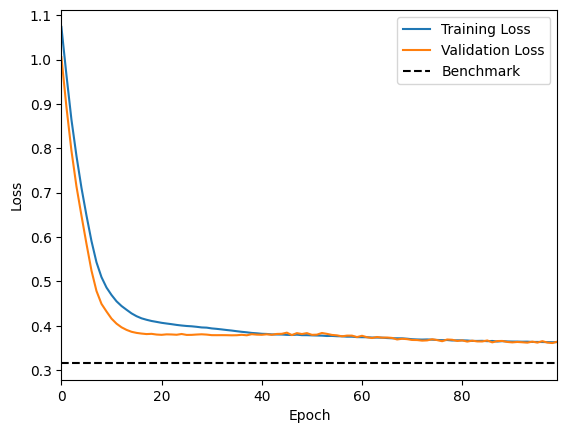

In [39]:
from for_rnn import plot_training

plot_training(epochs, train_losses, val_losses, std_bm)

## Implement the RNN in Deeplay

We now implement the RNN in deeplay.

In [41]:
import deeplay as dl

rnn_dl = dl.RecurrentModel(
    in_features=14,
    hidden_features=[2],
    out_features=1,
    rnn_type="RNN",
)
rnn_simple = dl.Regressor(rnn_dl, optimizer=dl.Adam(lr=0.001)).create()

print(rnn_simple)

Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RecurrentModel(
    (blocks): LayerList(
      (0): RecurrentBlock(
        (layer): RNN(14, 2, batch_first=True)
        (activation): Identity()
        (normalization): Identity()
        (dropout): RecurrentDropout(
          (dropout): Dropout(p=0, inplace=False)
        )
      )
      (1): LayerActivationNormalizationDropout(
        (layer): Linear(in_features=2, out_features=1, bias=True)
        (activation): Identity()
        (normalization): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (optimizer): Adam[Adam](lr=0.001)
)


We define a trainer that saves training and validation losses at the end of each epoch. The learning curves are plotted together with the common-sense benchmark.

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
2024-03-25 18:38:12.319579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ RecurrentModel   │     39 │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 39                                                                                               
Non-trainable params: 0                                                                                            
Total params: 39                                                                                                   
Total estimated model params size (MB): 0

Output()

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/conn
ectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/conn
ectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider
increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

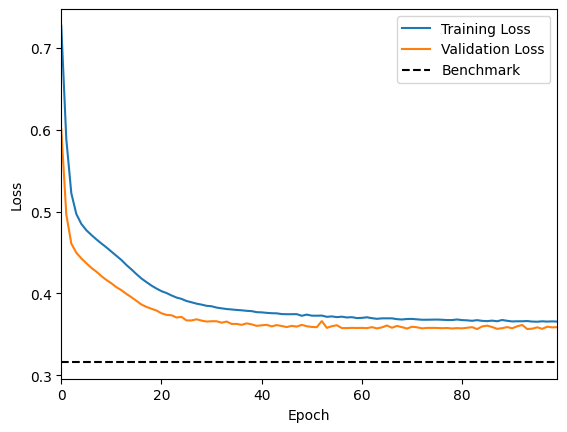

In [42]:
trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(rnn_simple, train_loader, val_loader)
train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, std_bm)

### Stacked RNN

In [48]:
rnn_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[32, 16],
    out_features=1,
    rnn_type="RNN",
)
rnn_stacked = dl.Regressor(rnn_dl, optimizer=dl.Adam(lr=0.0001)).create()

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ RecurrentModel   │  2.4 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 2.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 K                                                                                                
Total estimated model params size (MB): 0

Output()

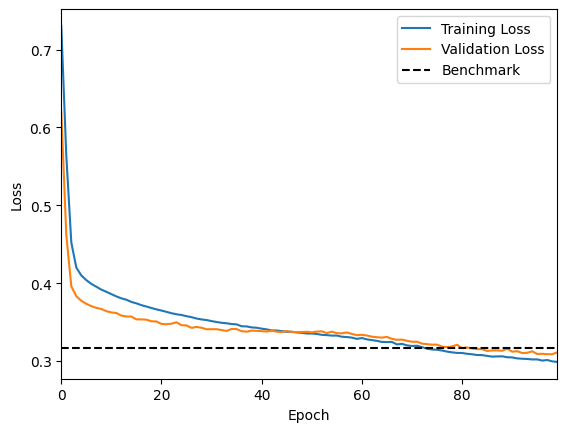

In [49]:
trainer = dl.Trainer(max_epochs=epochs, accelerator="cpu")
trainer.fit(rnn_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, std_bm)

### Stacked GRU

In [50]:
gru_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[32, 16],
    out_features=1,
    rnn_type="GRU",
    # dropout=0.1,
)
gru_stacked = dl.Regressor(gru_dl, optimizer=dl.Adam(lr=0.001)).create()

print(gru_stacked)

Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RecurrentModel(
    (blocks): LayerList(
      (0): RecurrentBlock(
        (layer): GRU(14, 32, batch_first=True)
        (activation): Identity()
        (normalization): Identity()
        (dropout): RecurrentDropout(
          (dropout): Dropout(p=0, inplace=False)
        )
      )
      (1): RecurrentBlock(
        (layer): GRU(32, 16, batch_first=True)
        (activation): Identity()
        (normalization): Identity()
        (dropout): RecurrentDropout(
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (2): LayerActivationNormalizationDropout(
        (layer): Linear(in_features=16, out_features=1, bias=True)
        (activation): Identity()
        (normalization): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (op

In [ ]:
trainer = dl.Trainer(max_epochs=epochs, accelerator="cpu")
trainer.fit(gru_stacked, train_loader, val_dataloaders=val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, std_bm)

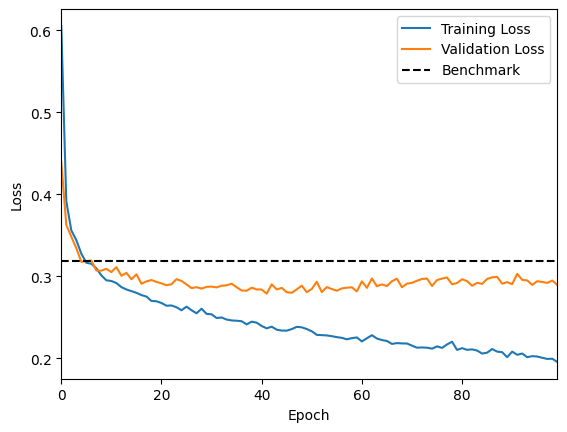

In [69]:
plot_training(
    epochs,
    train_losses,
    val_losses,
    benchmark / std_train[temp_idx],
)

### Stacked LSTM

In [ ]:
lstm_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[32, 16],
    out_features=1,
    rnn_type="LSTM",
    dropout=0.2,
)
lstm_stacked = dl.Regressor(lstm_dl, optimizer=dl.Adam(lr=0.001)).create()

print(lstm_stacked)

In [ ]:
trainer = dl.Trainer(max_epochs=epochs, accelerator="cpu")
trainer.fit(lstm_stacked, train_loader, val_dataloaders=val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(
    epochs,
    train_losses,
    val_losses,
    benchmark / std_train[temp_idx],
)

## Implementing a Preprocessor

We now introduce a dense preprocessor in feature space.

In [ ]:
preprocessor = dl.MultiLayerPerceptron(
    in_features=None,
    hidden_features=[32],
    out_features=8,
)
preprocessor.dropout.configure(p=0.2)

lstm_dl = dl.RecurrentModel(
    in_features=8,
    hidden_features=[32, 16],
    out_features=1,
    dropout=0.2,
    rnn_type="GRU",
)

from deeplay import DeeplayModule


class Reshape(DeeplayModule):
    """Custom reshape layer."""

    def __init__(self, new_shape):
        """Custom reshape layer."""
        super().__init__()

        self.new_shape = new_shape

    def forward(self, x):
        """Define the forward pass for the reshape layer."""
        return x.view(self.new_shape)


lstm_pre_dl = dl.Sequential(
    torch.nn.Flatten(
        start_dim=0, end_dim=1
    ),  # HENRIK, shouldn't this be included in a deeplay layer?
    preprocessor,
    Reshape((-1, pred_window, 8)),
    lstm_dl,
)
lstm_pre = dl.Regressor(lstm_pre_dl).create()

print(lstm_pre)

trainer_pre = dl.Trainer(
    max_epochs=epochs,
    accelerator="cpu",
)
trainer_pre.fit(lstm_pre, train_loader, val_loader)

train_losses = trainer_pre.history.history["train_loss_epoch"]["value"]
val_losses = trainer_pre.history.history["val_loss_epoch"]["value"][1:]
plot_training(
    epochs,
    train_losses,
    val_losses,
    benchmark / std_train[temp_idx],
)